In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/AVP")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [202]:
import os
os.chdir("/content/gdrive/My Drive/AVP")

!ls

classifier_10.pkl	       spacy_sentiment_clf_bow.py
meta.json		       spacy_sentiment_clf_ensemble.py
models			       spacy_sentiment_clf.py
sample_submission_i5xnIZD.csv  test.csv
spacy_clf.py		       textcat
spacy_model_bow		       tokenizer
spacy_model_cnn		       train_F3WbcTw.csv
spacy_model_ensemble	       vocab


In [0]:
import spacy

In [10]:
%%writefile spacy_clf.py
#!/usr/bin/env python
# coding: utf8
"""Train a convolutional neural network text classifier on the
IMDB dataset, using the TextCategorizer component. The dataset will be loaded
automatically via Thinc's built-in dataset loader. The model is added to
spacy.pipeline, and predictions are available via `doc.cats`. For more details,
see the documentation:
* Training: https://spacy.io/usage/training

Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_texts=("Number of texts to train from", "option", "t", int),
    n_iter=("Number of training iterations", "option", "n", int),
    init_tok2vec=("Pretrained tok2vec weights", "option", "t2v", Path)
)
def main(model=None, output_dir=None, n_iter=5, n_texts=2000, init_tok2vec=None):
    spacy.prefer_gpu()

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()

    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.create_pipe(
            "textcat",
            config={
                "exclusive_classes": True,
                "architecture": "simple_cnn",
            }
        )
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe("textcat")

    # add label to text classifier
    textcat.add_label("POSITIVE")
    textcat.add_label("NEGATIVE")

    # load the IMDB dataset
    print("Loading IMDB data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data()
    train_texts = train_texts[:n_texts]
    train_cats = train_cats[:n_texts]
    print(
        "Using {} examples ({} training, {} evaluation)".format(
            n_texts, len(train_texts), len(dev_texts)
        )
    )
    train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        if init_tok2vec is not None:
            with init_tok2vec.open("rb") as file_:
                textcat.model.tok2vec.from_bytes(file_.read())
        print("Training the model...")
        print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print(
                "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                    losses["textcat"],
                    scores["textcat_p"],
                    scores["textcat_r"],
                    scores["textcat_f"],
                )
            )

    # test the trained model
    test_text = "This movie sucked"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        with nlp.use_params(optimizer.averages):
            nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)


def load_data(limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    train_data, _ = thinc.extra.datasets.imdb()
    random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])


def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


if __name__ == "__main__":
    plac.call(main)



Overwriting spacy_clf.py


In [40]:
%%writefile spacy_sentiment_clf_bow.py
#!/usr/bin/env python
# coding: utf8
"""Train a convolutional neural network text classifier on the
IMDB dataset, using the TextCategorizer component. The dataset will be loaded
automatically via Thinc's built-in dataset loader. The model is added to
spacy.pipeline, and predictions are available via `doc.cats`. For more details,
see the documentation:
* Training: https://spacy.io/usage/training

Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets
import pandas as pd
import spacy
from spacy.util import minibatch, compounding


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_texts=("Number of texts to train from", "option", "t", int),
    n_iter=("Number of training iterations", "option", "n", int),
    init_tok2vec=("Pretrained tok2vec weights", "option", "t2v", Path)
)
def main(model=None, output_dir='./spacy_model_bow', n_iter=20, n_texts=150000, init_tok2vec=None):
    spacy.prefer_gpu()

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()

    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.create_pipe(
            "textcat",
            config={
                "exclusive_classes": True,
                "architecture": "bow",
            }
        )
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe("textcat")

    # add label to text classifier
    textcat.add_label("POSITIVE")
    textcat.add_label("NEGATIVE")
    textcat.add_label("NEUTRAL")
    # load the IMDB dataset
    print("Loading IMDB data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data()
    train_texts = train_texts[:n_texts]
    train_cats = train_cats[:n_texts]
    print(
        "Using {} examples ({} training, {} evaluation)".format(
            n_texts, len(train_texts), len(dev_texts)
        )
    )
    train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        if init_tok2vec is not None:
            with init_tok2vec.open("rb") as file_:
                textcat.model.tok2vec.from_bytes(file_.read())
        print("Training the model...")
        print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print(
                "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                    losses["textcat"],
                    scores["textcat_p"],
                    scores["textcat_r"],
                    scores["textcat_f"],
                )
            )

    # test the trained model
    test_text = "This movie sucked"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        with nlp.use_params(optimizer.averages):
            nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)


def load_data(limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    #train_data, _ = thinc.extra.datasets.imdb()
    train_data=pd.read_csv("train_F3WbcTw.csv",usecols=['text','sentiment'])
    #random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts=train_data['text'].tolist()
    labels=train_data['sentiment'].tolist()
    #texts, labels = zip(*train_data)
    #Target) 0-positive, 1-negative, 2-neutral
    cats = [{"POSITIVE": y==0, "NEGATIVE": y==1,"NEUTRAL":y==2} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])


def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


if __name__ == "__main__":
    plac.call(main)


Overwriting spacy_sentiment_clf_bow.py


In [34]:
!nvidia-smi


Sat Jul 27 13:03:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   1455MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
!pip install -U spacy[cuda100]

Requirement already up-to-date: spacy[cuda100] in /usr/local/lib/python3.6/dist-packages (2.1.6)
     |████████████████████████████████| 491kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/eb/ba/a3/9af9f326ed0d75a4540378af64a05a0e42be39d9b8513f3aea
Successfully built thinc-gpu-ops


In [9]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [36]:
import spacy
spacy.prefer_gpu()


True

In [167]:
!spacy download en_vectors_web_lg


     |████████████████████████████████| 661.8MB 3.9MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-v193m6zl/wheels/ce/3e/83/59647d0b4584003cce18fb68ecda2866e7c7b2722c3ecaddaf
Successfully built en-vectors-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')


In [172]:
spacy.load('/tmp/pip-ephem-wheel-cache-v193m6zl/wheels/ce/3e/83/59647d0b4584003cce18fb68ecda2866e7c7b2722c3ecaddaf')

OSError: ignored

In [11]:
!python spacy_clf.py

Created blank 'en' model
Loading IMDB data...
Using 2000 examples (2000 training, 5000 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
10.434	0.716	0.851	0.778
1.700	0.797	0.768	0.782
0.484	0.801	0.781	0.791
0.144	0.803	0.770	0.786
0.046	0.795	0.778	0.786
This movie sucked {'POSITIVE': 0.24886733293533325, 'NEGATIVE': 0.7511326670646667}


In [12]:
!ls

classifier_10.pkl  sample_submission_i5xnIZD.csv  test.csv
models		   spacy_clf.py			  train_F3WbcTw.csv


In [37]:
train.text.apply(lambda x:len(x))

NameError: ignored

In [24]:
!python spacy_sentiment_clf.py

tcmalloc: large alloc 1285169152 bytes == 0x1e7b0000 @  0x7f233e4911e7 0x7f233b546ca1 0x7f233b5b09c5 0x7f233b5b155e 0x7f233b64aa6e 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f6128 0x4f8ff9 0x7f2298cc0cc8 0x7f2298cce4ad 0x57ec0c 0x4f88ba 0x4f98c7 0x7f2298cbe8e0 0x7f2298cc0ddf 0x7f2298ccd2e6 0x562433 0x7f2299d5a921 0x4f8925 0x4f98c7 0x4f6128 0x4f7d60
Loaded model 'en_vectors_web_lg'
Loading IMDB data...
Using 150000 examples (4223 training, 1056 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
13.301	0.736	0.853	0.790
1.657	0.755	0.826	0.789
0.491	0.749	0.797	0.772
0.257	0.751	0.794	0.772
0.089	0.744	0.789	0.766
This movie sucked {'POSITIVE': 0.0018460321007296443, 'NEGATIVE': 0.10647808015346527, 'NEUTRAL': 0.8916759490966797}
tcmalloc: large alloc 1285169152 bytes == 0x2e0fe000 @  0x7f233e4911e7 0x7f233b546ca1 0x7f233b5ab778 0x7f233b5abd47 0x7f233b646038 0x562433 0x7f2333aeb286 0x7f2333a56927 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60

In [25]:
!ls 

classifier_10.pkl	       spacy_clf.py	       textcat
meta.json		       spacy_model_cnn	       tokenizer
models			       spacy_sentiment_clf.py  train_F3WbcTw.csv
sample_submission_i5xnIZD.csv  test.csv		       vocab


In [0]:
import pandas as pd
import spacy
simple_cnn=spacy.load("spacy_model_cnn/")
train_data=pd.read_csv("train_F3WbcTw.csv")


In [19]:

res=simple_cnn(train_data.loc[1,'text'])
res,res.cats,train_data.loc[1,'sentiment']

(I can completely understand why you’d want to try it. But, results reported in lectures don’t always stand up to the scrutiny of peer-review during publication. There so much still to do before this is convincing. I hope that it does work out, I really do. And if you’re aware of and happy with the risks, then that’s great. I just think it’s important to present this in a balanced way, and to understand why we don’t move straight from the first show of promise in an animal study to using drugs on humans. There’s still a lot of animal data to gather, and human data to gather before anyone can tell if it’s safe or effective. I can’t tell you how many times animal studies don’t follow through to humans, but it’s one of the major attrition points in drug development. You’ve been through some of the unpredictability issues with Cladribine/Gilenya, where there was an interaction that wasn’t predicted. But once people try it, the doctors can see patterns and work out what’s going on. Clemasti

In [20]:
list(res.cats.values())

[0.06163908168673515, 0.1906452625989914, 0.7477155923843384]

In [22]:
res.vector

array([-4.76820320e-02,  2.06838980e-01, -2.15403736e-01, -2.91413181e-02,
       -8.28139856e-03,  5.21984659e-02, -1.68840624e-02, -7.53674209e-02,
        8.19206052e-03,  2.32263994e+00, -2.24296376e-01,  3.35979313e-02,
        1.00102998e-01, -7.51464395e-05, -1.07479431e-01, -6.82344288e-02,
       -9.63611230e-02,  1.12498963e+00, -2.29473114e-01, -3.43182907e-02,
        3.29538956e-02,  8.92571453e-03, -4.79429141e-02, -3.83488238e-02,
       -2.67121010e-02,  5.68099059e-02, -1.13331741e-02, -7.60330260e-02,
        7.79576376e-02, -1.30371228e-01, -6.24230541e-02,  6.65857941e-02,
       -2.88768392e-02,  3.87700871e-02,  8.15868601e-02, -4.29297052e-02,
        6.56552613e-02,  5.77039458e-02, -5.15230112e-02, -7.58526027e-02,
       -3.87492627e-02,  3.85197811e-02,  1.91315624e-03, -8.24856237e-02,
        4.00378928e-02,  5.43605238e-02, -1.60740599e-01, -1.40676741e-02,
        3.54373973e-04, -2.93513611e-02, -6.92997202e-02,  2.15738658e-02,
        1.71790583e-04, -

In [33]:
res.cats.values()

dict_values([0.06163908168673515, 0.1906452625989914, 0.7477155923843384])

In [0]:
def spacy_classify(x,model):
  sent=model(x)
  return np.argmax(np.array(list(sent.cats.values())))
def spacy_vector(x,model):
  sent=model(x)
  return sent.vector.reshape(1,-1)

In [0]:
pred=train_data.text.apply(lambda x:spacy_classify(x,simple_cnn))

In [41]:
pred

0       {'POSITIVE': 0.07647152245044708, 'NEGATIVE': ...
1       {'POSITIVE': 0.06163908168673515, 'NEGATIVE': ...
2       {'POSITIVE': 0.036934249103069305, 'NEGATIVE':...
3       {'POSITIVE': 0.0035667286720126867, 'NEGATIVE'...
4       {'POSITIVE': 0.14029201865196228, 'NEGATIVE': ...
5       {'POSITIVE': 0.009869048371911049, 'NEGATIVE':...
6       {'POSITIVE': 0.3752500116825104, 'NEGATIVE': 0...
7       {'POSITIVE': 0.014408943243324757, 'NEGATIVE':...
8       {'POSITIVE': 0.016299284994602203, 'NEGATIVE':...
9       {'POSITIVE': 0.018412573263049126, 'NEGATIVE':...
10      {'POSITIVE': 0.11350857466459274, 'NEGATIVE': ...
11      {'POSITIVE': 0.021082013845443726, 'NEGATIVE':...
12      {'POSITIVE': 0.12878458201885223, 'NEGATIVE': ...
13      {'POSITIVE': 0.09864801168441772, 'NEGATIVE': ...
14      {'POSITIVE': 0.18555481731891632, 'NEGATIVE': ...
15      {'POSITIVE': 0.04482552781701088, 'NEGATIVE': ...
16      {'POSITIVE': 0.015619627200067043, 'NEGATIVE':...
17      {'POSI

In [13]:
import numpy as np
pred_array=np.array([list(p.values()) for p in pred])

NameError: ignored

In [47]:
from collections import Counter
Counter(np.argmax(pred_array,axis=1))

Counter({0: 326, 1: 521, 2: 4432})

In [49]:
Counter(train_data.loc[:,"sentiment"])

Counter({0: 617, 1: 837, 2: 3825})

In [16]:
pred_vector=train_data.text.apply(lambda x:spacy_vector(x,simple_cnn))

NameError: ignored

In [0]:
pred_vector.reshape(-1,300).shape

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline



In [18]:
pca=PCA(n_components=3)
feat_3d_numpy=pca.fit_transform(pred_vector.reshape(-1,300))

NameError: ignored

In [1]:
plt.figure(figsize=(20,15))
plt.scatter(feat_3d_numpy[:,0],feat_3d_numpy[:,1],c=pred_array)
plt.show()

NameError: ignored

In [0]:
len_text=train_data.text.apply(lambda x:len(x))
len_token=train_data.text.apply(lambda x:len(x.split(' ')))

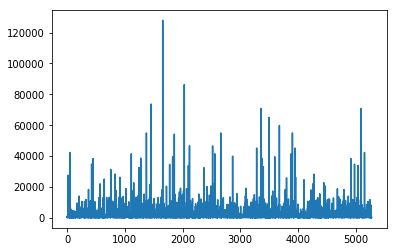

In [40]:
plt.plot(len_text)
plt.show()

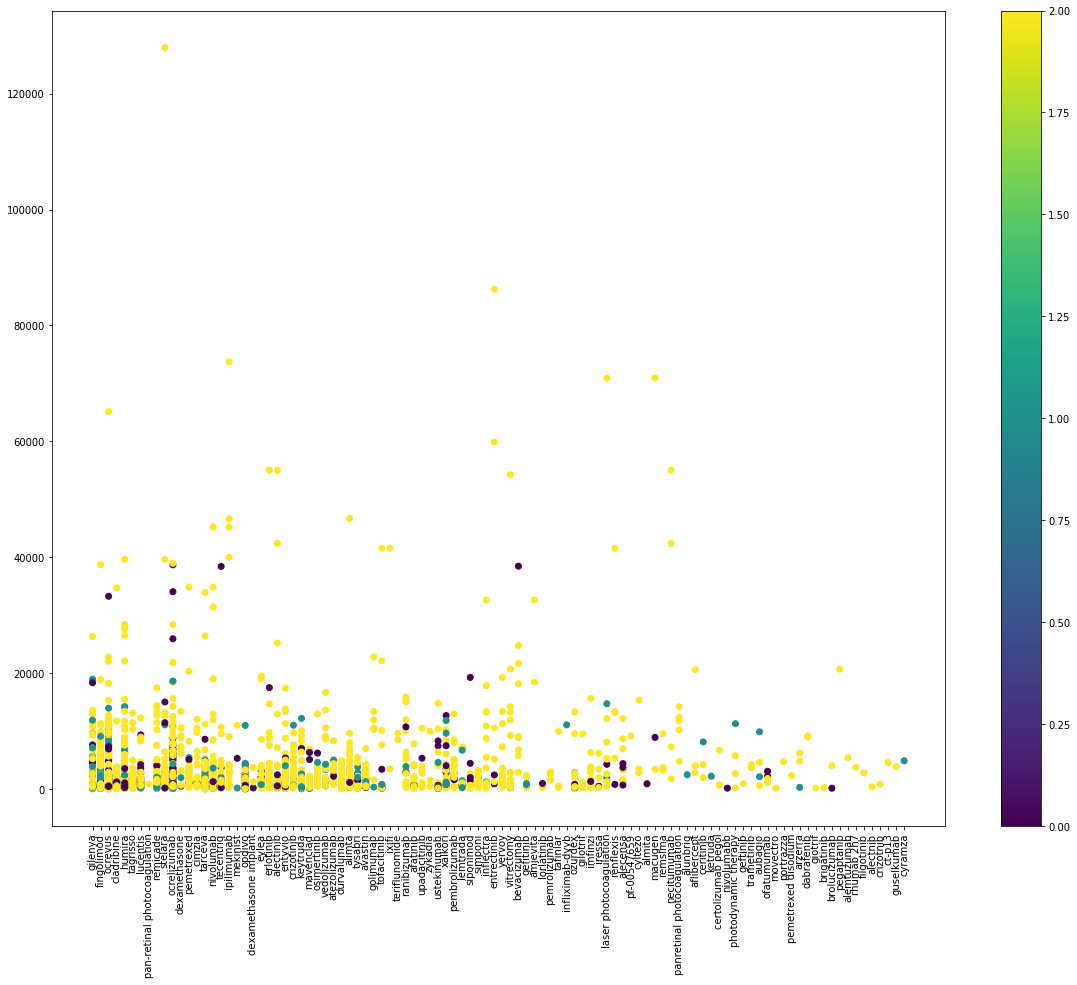

In [46]:
plt.figure(figsize=(20,15))
plt.scatter(train_data.drug,len_text,c=train_data.sentiment)
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

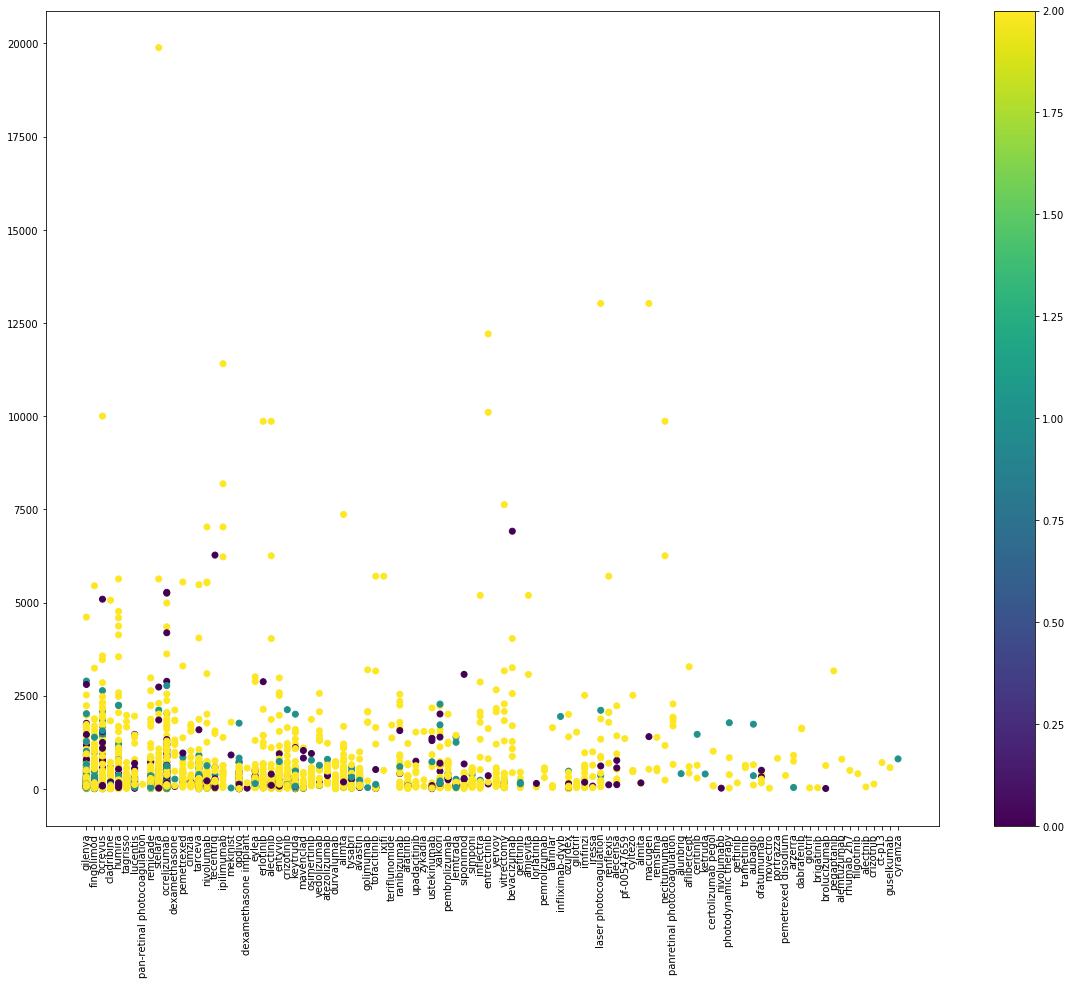

In [48]:
plt.figure(figsize=(20,15))
plt.scatter(train_data.drug,len_token,c=train_data.sentiment)
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

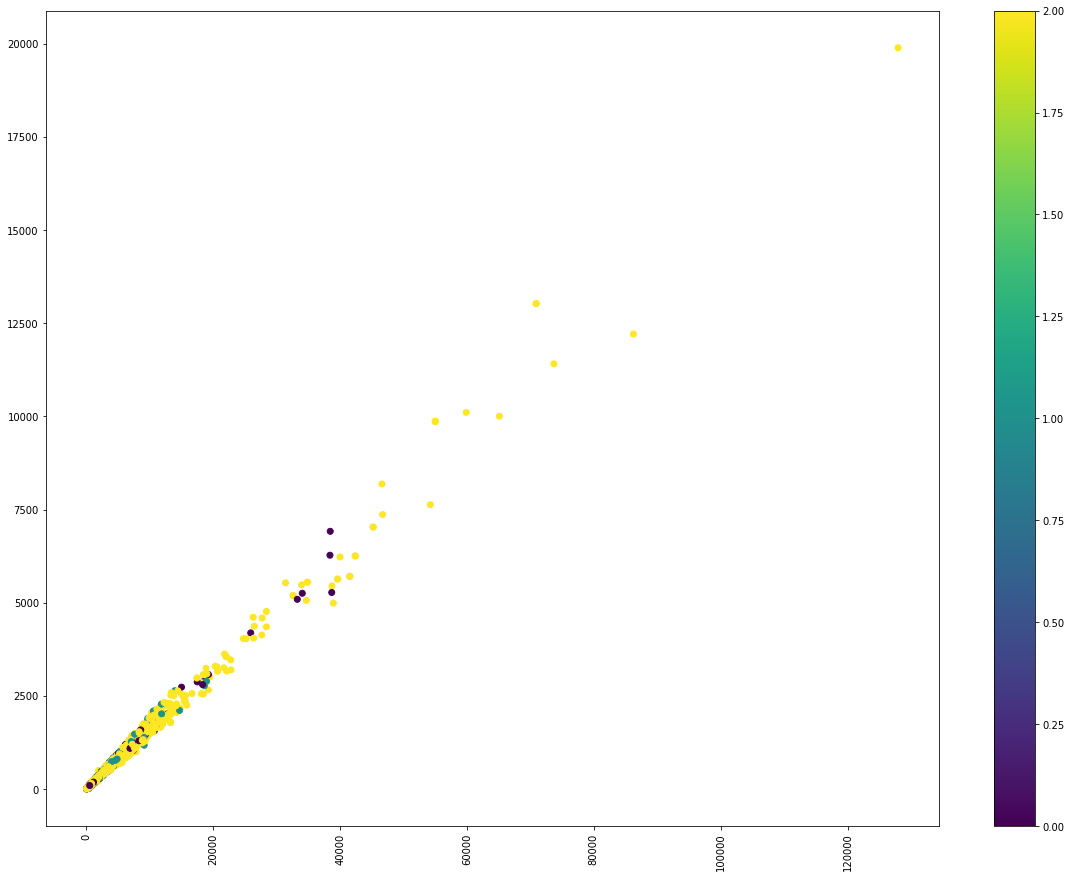

In [49]:
plt.figure(figsize=(20,15))
plt.scatter(len_text,len_token,c=train_data.sentiment)
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

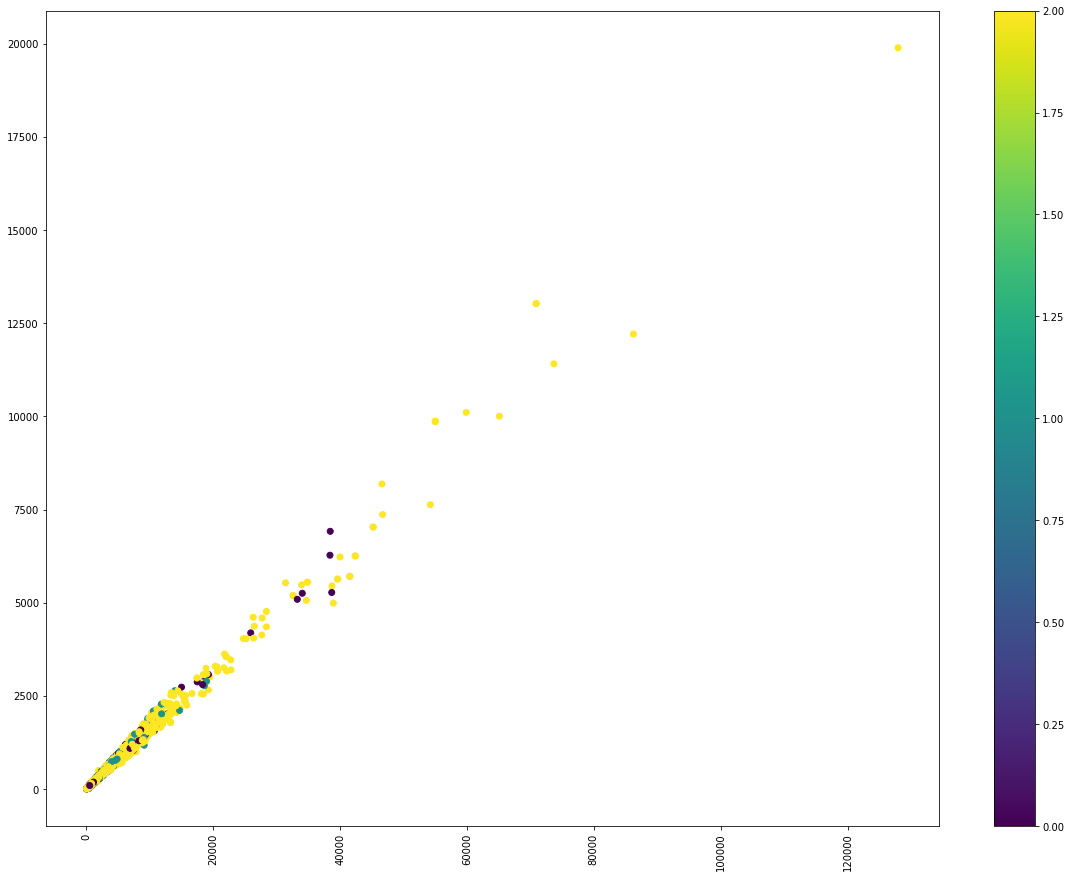

In [51]:
plt.figure(figsize=(20,15))
plt.scatter(len_text,len_token,c=train_data.sentiment)
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [0]:
tfidf=TfidfVectorizer()
vect=tfidf.fit_transform(train_data.text)

In [54]:
vect.shape

(5279, 41015)

In [68]:
list(zip(tfidf.get_feature_names() ,tfidf.idf_.tolist()))[-1000:]

[('weighing', 6.313584838678825),
 ('weighs', 8.185387015580417),
 ('weight', 4.2341432969989885),
 ('weightbased', 7.269096283706261),
 ('weighted', 7.779921907472252),
 ('weighting', 8.878534196140361),
 ('weights', 7.779921907472252),
 ('weil', 8.473069088032197),
 ('weill', 7.779921907472252),
 ('weinberg', 8.473069088032197),
 ('weinblatt', 8.473069088032197),
 ('weiner', 8.185387015580417),
 ('weinman', 7.962243464266207),
 ('weir', 8.473069088032197),
 ('weird', 5.564348191467836),
 ('weirder', 8.878534196140361),
 ('weirdly', 8.878534196140361),
 ('weirdness', 8.878534196140361),
 ('weis', 8.878534196140361),
 ('weiss', 7.269096283706261),
 ('weitzman', 8.185387015580417),
 ('welchol', 8.185387015580417),
 ('welcome', 4.688879454113936),
 ('welcomed', 7.173786103901937),
 ('welcomes', 8.473069088032197),
 ('welcoming', 8.878534196140361),
 ('welfare', 7.962243464266207),
 ('well', 2.400792898187802),
 ('wellbeing', 7.625771227644994),
 ('wellbutrin', 7.00673201923877),
 ('wellc

In [0]:
pca=PCA(n_components=3)
vect_pca=pca.fit_transform(vect.toarray())

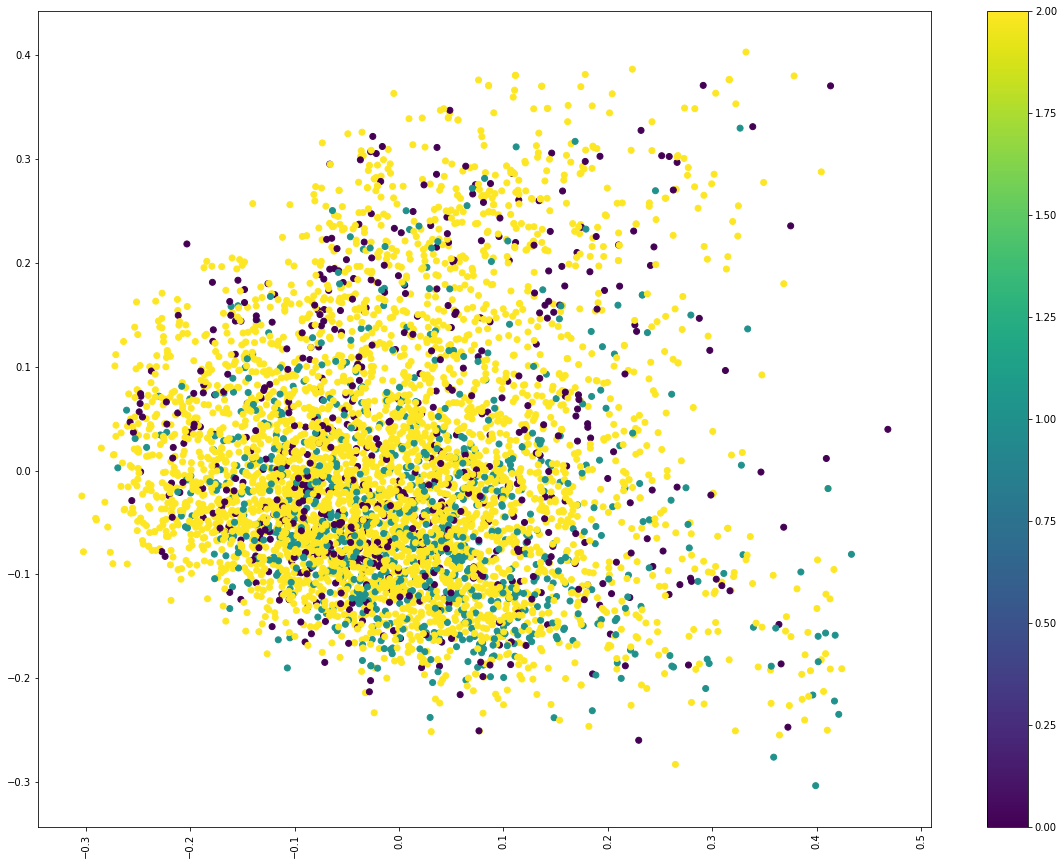

In [71]:
plt.figure(figsize=(20,15))
plt.scatter(vect_pca[:,0],vect_pca[:,1],c=train_data.sentiment)
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

In [13]:
!python spacy_sentiment_clf_ensemble.py

Created blank 'en' model
Loading IMDB data...
Using 150000 examples (4223 training, 1056 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
13.215	0.724	0.861	0.786
1.661	0.756	0.800	0.778
0.480	0.763	0.772	0.768
0.247	0.768	0.777	0.772
0.094	0.759	0.762	0.760
This movie sucked {'POSITIVE': 0.10012082010507584, 'NEGATIVE': 0.048054829239845276, 'NEUTRAL': 0.8518244028091431}
Saved model to spacy_model_ensemble
Loading from spacy_model_ensemble
This movie sucked {'POSITIVE': 0.11639296263456345, 'NEGATIVE': 0.07752852141857147, 'NEUTRAL': 0.8060785531997681}


In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [0]:
spacy_ensemble=spacy.load("spacy_model_ensemble/")

In [27]:
pred_vector=train_data.text.apply(lambda x:spacy_vector(x,spacy_ensemble))


NameError: ignored

In [36]:
pred_array=np.array([p.reshape(1,-1) for p in pred_vector])
pred_array.shape

(5279, 1, 0)

In [35]:
pred=train_data.text.apply(lambda x:spacy_classify(x,spacy_ensemble))
confusion_matrix(train_data.loc[:,'sentiment'].values,pred)

array([[ 200,  115,  302],
       [  21,  470,  346],
       [  29,  105, 3691]])

In [38]:
spacy_cnn=spacy.load("spacy_model_cnn")
pred=train_data.text.apply(lambda x:spacy_classify(x,spacy_cnn))
confusion_matrix(train_data.loc[:,'sentiment'].values,pred)

array([[ 256,   25,  336],
       [  12,  415,  410],
       [  58,   81, 3686]])

In [45]:
!python spacy_sentiment_clf_bow.py

Created blank 'en' model
Loading IMDB data...
Using 150000 examples (4223 training, 1056 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
14.072	0.741	0.779	0.759
1.314	0.743	0.747	0.745
0.339	0.732	0.754	0.743
0.131	0.737	0.765	0.751
0.057	0.731	0.763	0.747
0.029	0.731	0.771	0.750
0.019	0.735	0.775	0.755
0.015	0.732	0.777	0.754
0.014	0.732	0.774	0.753
0.013	0.727	0.764	0.745
0.012	0.726	0.770	0.747
0.011	0.726	0.769	0.746
0.010	0.725	0.772	0.748
0.009	0.724	0.767	0.745
0.009	0.723	0.769	0.745
0.008	0.730	0.775	0.752
0.008	0.727	0.773	0.750
0.008	0.729	0.775	0.751
0.007	0.723	0.770	0.746
0.007	0.721	0.766	0.743
This movie sucked {'POSITIVE': 0.24832792580127716, 'NEGATIVE': 0.1622154712677002, 'NEUTRAL': 0.5894566178321838}
Saved model to spacy_model_bow
Loading from spacy_model_bow
This movie sucked {'POSITIVE': 0.2555693984031677, 'NEGATIVE': 0.1634932905435562, 'NEUTRAL': 0.5809373259544373}


In [0]:
from collections import Counter

In [49]:
Counter(['d','d'])

Counter({'d': 2})

In [50]:
sum([True,True])

2

In [55]:
spacy.parts_of_speech
spacy.

AttributeError: ignored

In [70]:
Counter([True,True,False])

Counter({False: 1, True: 2})

In [81]:
res=train_data.text.apply(lambda x:Counter([token.pos_  for token in spacy_cnn(x) if len(token.pos_)>0 ]))
res

0              {'ADV': 4, 'AUX': 1, 'PRON': 3, 'VERB': 3}
1              {'PRON': 7, 'AUX': 3, 'ADV': 6, 'VERB': 2}
2            {'PRON': 3, 'VERB': 2, 'SPACE': 1, 'ADV': 2}
3                                                      {}
4                                  {'PRON': 1, 'VERB': 1}
5                                    {'AUX': 1, 'ADV': 1}
6                                                      {}
7                                              {'ADV': 3}
8                                                      {}
9          {'SPACE': 6, 'PRON': 2, 'VERB': 2, 'CCONJ': 1}
10                                  {'ADV': 1, 'PRON': 1}
11                      {'SPACE': 2, 'ADV': 2, 'VERB': 1}
12                                                     {}
13                              {'SPACE': 64, 'CCONJ': 1}
14                                                     {}
15          {'SPACE': 31, 'AUX': 1, 'ADV': 1, 'CCONJ': 1}
16                                                     {}
17            

In [83]:
resdf=pd.DataFrame.from_dict(res.values.tolist()).fillna(0)
resdf.head()

,ADV,AUX,CCONJ,PRON,SPACE,VERB
0,4.0,1.0,0.0,3.0,0.0,3.0
1,6.0,3.0,0.0,7.0,0.0,2.0
2,2.0,0.0,0.0,3.0,1.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0


In [80]:
res

,0,1,2,3,4,5
0,4.0,1.0,0.0,3.0,0.0,3.0
1,6.0,3.0,0.0,7.0,0.0,2.0
2,2.0,0.0,0.0,3.0,1.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0
5,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,2.0,6.0,2.0


In [0]:
res=train_data.text.apply(lambda x:sum([token.is_alpha  for token in spacy_cnn(x)  ]))

In [0]:
#res1=res.copy()
res1.name="is_alpha"

In [88]:
pd.concat([resdf,res1],axis=1)

,ADV,AUX,CCONJ,PRON,SPACE,VERB,is_alpha
0,4.0,1.0,0.0,3.0,0.0,3.0,76
1,6.0,3.0,0.0,7.0,0.0,2.0,209
2,2.0,0.0,0.0,3.0,1.0,2.0,117
3,0.0,0.0,0.0,0.0,0.0,0.0,20
4,0.0,0.0,0.0,1.0,0.0,1.0,109
5,1.0,1.0,0.0,0.0,0.0,0.0,36
6,0.0,0.0,0.0,0.0,0.0,0.0,114
7,3.0,0.0,0.0,0.0,0.0,0.0,139
8,0.0,0.0,0.0,0.0,0.0,0.0,50
9,0.0,0.0,1.0,2.0,6.0,2.0,160


In [0]:
#%load_ext Cython
from numba import jit


In [0]:
del enrich_linguistic_feat

In [0]:
#@jit
def enrich_linguistic_feat(spacy_model,df):
        # pos=[]
        # tag=[]
        # dep=[]
        # is_alpha=[]
        # is_stop=[]
        # for token in doc:
        #     pos.append(token.pos_)
        #     tag.append(token.tag_)
        #     dep.append(token.dep_)
        #     is_alpha.append(token.is_alpha)
        #     is_stop.append(token.is_stop)
        # d=defaultdict({})
        # d['pos']=Counter(pos)
        # d['tag']=Counter(tag)
        # d['dep']=Counter(dep)
        # d[]
        # pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
        # # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        # #         token.shape_, token.is_alpha, token.is_stop)
        pos=df.text.apply(lambda x:Counter([token.pos_ \
             for token in spacy_model(x) if len(token.pos_)>0 ]))
        tag=df.text.apply(lambda x:Counter([token.tag_ \
             for token in spacy_model(x) if len(token.tag_)>0 ]))
        dep=df.text.apply(lambda x:Counter([token.dep_ \
             for token in spacy_model(x) if len(token.dep_)>0 ]))
        # is_alpha=train_data.text.apply(lambda x:Counter([token.pos_ \
        #      for token in spacy_model(x) if len(token.pos_)>0 ]))
        is_alpha=df.text.apply(lambda x:sum([token.is_alpha \
              for token in spacy_model(x)  ]))
        is_alpha.name="is_alpha"
        is_stop=df.text.apply(lambda x:sum([token.is_stop \
              for token in spacy_model(x)  ]))
        is_stop.name="is_stop"
        
        
        #sentcount=df.text.apply(lambda x:len([sent.text \
        #      for sent in spacy_model(x).sents  ]))
        #sentcount.name="sentcount"
        
        ner=df.text.apply(lambda x:Counter([ent.label_ \
             for ent in spacy_model(x).ents if len(ent.label_)>0 ]))
        ner.name="ner"
        posdf=pd.DataFrame.from_dict(pos.values.tolist()).fillna(0)
        tagdf=pd.DataFrame.from_dict(tag.values.tolist()).fillna(0)
        depdf=pd.DataFrame.from_dict(dep.values.tolist()).fillna(0)
        res=pd.concat([posdf,tagdf,depdf,is_alpha,is_stop,sentcount,ner],axis=1)
        print(res.head())
        return res


In [0]:
spacy_model=spacy_cnn
df=train_data
#spacy_model.add_pipe(spacy_model.create_pipe('sentencizer'))
#sentcount=df.text.apply(lambda x:len([sent.text \
#              for sent in spacy_model(x).sents  ]))

#sentcount.name="sentcount"
        
ner=df.text.apply(lambda x:Counter([ent.label_ \
     for ent in spacy_model(x).ents if len(ent.label_)>0 ]))


In [118]:
pd.DataFrame.from_dict(ner.values)

0    0
dtype: int64

In [104]:
finalres=enrich_linguistic_feat(spacy_cnn,train_data)

ValueError: ignored

In [0]:
ch_sent=df.text.apply(lambda x :spacy_model(x).sentiment)

In [120]:
Counter(ch_sent)

Counter({0.0: 5279})

In [114]:
spacy_model(df.loc[0,'text']).sentiment

0.0

In [0]:
from textblob import sentiments,TextBlob

In [135]:
TextBlob(df.loc[0,'text']).polarity

0.22916666666666666

In [0]:
def textblob_sentiment(x):
  tmp=TextBlob(x)
  return (tmp.polarity,tmp.subjectivity)
aa=df.text.apply(lambda x:textblob_sentiment(x))

In [134]:
dict(aa)

{0: (0.22916666666666666, 0.4069444444444444),
 1: (0.2876249999999999, 0.5066666666666667),
 2: (0.18239105339105338, 0.6077210197210197),
 3: (0.575, 0.825),
 4: (0.2281818181818182, 0.46045454545454545),
 5: (0.0, 0.0),
 6: (0.2, 0.4898148148148148),
 7: (0.18766233766233767, 0.4508658008658009),
 8: (-0.36333333333333334, 0.44000000000000006),
 9: (-0.0025000000000000022, 0.6866666666666668),
 10: (0.08801470588235294, 0.42511437908496735),
 11: (0.266005291005291, 0.5308201058201057),
 12: (0.13449197860962567, 0.38065953654188955),
 13: (0.051984173234173245, 0.3688904649481573),
 14: (-0.025694444444444426, 0.604861111111111),
 15: (0.026015064619079237, 0.4329817597244606),
 16: (0.18375, 0.4154166666666666),
 17: (0.19211760461760463, 0.47727272727272724),
 18: (0.1960227272727273, 0.451010101010101),
 19: (0.171780303030303, 0.4920454545454546),
 20: (0.10888888888888888, 0.44249999999999995),
 21: (0.2928571428571428, 0.7178571428571429),
 22: (0.2549019607843137, 0.46323529

In [133]:
pd.DataFrame.from_dict(dict(aa)).T

,0,1
0,0.229167,0.406944
1,0.287625,0.506667
2,0.182391,0.607721
3,0.575000,0.825000
4,0.228182,0.460455
5,0.000000,0.000000
6,0.200000,0.489815
7,0.187662,0.450866
8,-0.363333,0.440000
9,-0.002500,0.686667


In [139]:
spacy_bow=spacy.load("spacy_model_bow")

spacy_ensemble,spacy_bow

(<spacy.lang.en.English at 0x7fcbc2937cc0>,
 <spacy.lang.en.English at 0x7fcbbdd2dc50>)

In [0]:
def spacy_vector(x,model):
    sent=model(x)
    return sent.vector.reshape(1,-1)


In [169]:
spacy_lg=spacy.load('en_vectors_web_lg')

OSError: ignored

In [0]:
def build_feat(df:pd.DataFrame,text_column:str):
    vector_combine=[]
    for model in [spacy_cnn,spacy_bow]:
        vector=df[text_column].apply(lambda x:spacy_vector(x,model))
        print(vector.shape,vector[0].shape)
        vector_combine.append(vector)
      
    return np.array(vector_combine).reshape(-1,300)


In [201]:
ss=build_feat(df.iloc[:10],"text")

(10,) (1, 300)
(10,) (1, 0)


ValueError: ignored

In [193]:
ss[0].shape,ss.reshape(-1,300).shape

((10, 1, 300), (10, 300))

In [255]:
%%writefile baselinemodel.py
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate,KFold
from typing import List
from collections import Counter,defaultdict
from sklearn.decomposition import TruncatedSVD
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import spacy

class SpacyModels(object):
    def __init__(self,path:str,model_filenames:List):
        self.path=path
        self.model_names_to_load=[spacy.load(name) for name in model_filenames]
    def spacy_classify(self,x,model):
        sent=model(x)
        return np.argmax(np.array(list(sent.cats.values())))
    def spacy_vector(self,x,model):
        sent=model(x)
        return sent.vector.reshape(1,-1)
    # def build_feat(self,df:pd.DataFrame,text_column:str):
    #     vector_combine=[]
    #     for model in self.model_names_to_load:
    #         vector=df[text_column].apply(lambda x:self.spacy_vector(x,model))
    #         vector_combine.append(vector)
    #     return np.hstact(vector_combine)

    def build_feat(self,df:pd.DataFrame,text_column:str):
        vector_combine=[]
        for model in self.model_names_to_load:
            vector=df[text_column].apply(lambda x:self.spacy_vector(x,model))
            print(vector.shape)
            if not vector[0].shape[1]==0:
                print(vector[0])
                vector_combine.append(vector)
        
        return np.array(vector_combine).reshape(-1,300)

    def enrich_linguistic_feat(self,spacy_model,df):
        # pos=[]
        # tag=[]
        # dep=[]
        # is_alpha=[]
        # is_stop=[]
        # for token in doc:
        #     pos.append(token.pos_)
        #     tag.append(token.tag_)
        #     dep.append(token.dep_)
        #     is_alpha.append(token.is_alpha)
        #     is_stop.append(token.is_stop)
        # d=defaultdict({})
        # d['pos']=Counter(pos)
        # d['tag']=Counter(tag)
        # d['dep']=Counter(dep)
        # d[]
        # pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
        # # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        # #         token.shape_, token.is_alpha, token.is_stop)
        pos=df.text.apply(lambda x:Counter([token.pos_ \
             for token in spacy_model(x) if len(token.pos_)>0 ]))
        tag=df.text.apply(lambda x:Counter([token.tag_ \
             for token in spacy_model(x) if len(token.tag_)>0 ]))
        dep=df.text.apply(lambda x:Counter([token.dep_ \
             for token in spacy_model(x) if len(token.dep_)>0 ]))
        # is_alpha=train_data.text.apply(lambda x:Counter([token.pos_ \
        #      for token in spacy_model(x) if len(token.pos_)>0 ]))
        is_alpha=df.text.apply(lambda x:sum([token.is_alpha \
              for token in spacy_model(x)  ]))
        is_alpha.name="is_alpha"
        is_stop=df.text.apply(lambda x:sum([token.is_stop \
              for token in spacy_model(x)  ]))
        is_stop.name="is_stop"
        
        len_text=train_data.text.apply(lambda x:len(x))
        len_token=train_data.text.apply(lambda x:len(x.split(' ')))
        #sentcount=df.text.apply(lambda x:len([sent.text \
        #      for sent in spacy_model(x).sents  ]))
        #sentcount.name="sentcount"
        
        #ner=df.text.apply(lambda x:Counter([ent.label_ \
        #     for ent in spacy_model(x).ents if len(ent.label_)>0 ]))
        #ner.name="ner"
        posdf=pd.DataFrame.from_dict(pos.values.tolist()).fillna(0)
        tagdf=pd.DataFrame.from_dict(tag.values.tolist()).fillna(0)
        depdf=pd.DataFrame.from_dict(dep.values.tolist()).fillna(0)
        
        res=pd.concat([posdf,tagdf,depdf,is_alpha,is_stop,len_text,len_token],axis=1)
        print(res.head())
        return res

    def sentiment(self,df,model):
        spacy_sent=df.text.apply(lambda x :model(x).sentiment)
        textblobFeat=df.text.apply(lambda x:self.textblob_sentiment(x))
        
        textblobFeat=pd.DataFrame.from_dict(dict(textblobFeat)).T
        return pd.concat([textblobFeat,spacy_sent],axis=1)

    def textblob_sentiment(self,x):
        tmp=TextBlob(x)
        return (tmp.polarity,tmp.subjectivity)
    
    def return_spacy_features(self,df):
        df1=self.enrich_linguistic_feat(self.model_names_to_load[0],df)
        df2=self.sentiment(df,self.model_names_to_load[0])
        df3=pd.DataFrame(self.build_feat(df,'text'))
        return pd.concat([df1,df2,df3],axis=1)

class BagoFWords(TransformerMixin):
    def __init__(self,estimators:List,est_names:List):
        self.est_list=estimators
        self.est_names=est_names
        self.pipeline=Pipeline(list(zip(self.est_names,self.est_list)))    
    def make_features_train(self,df):
        return pd.DataFrame(self.pipeline.fit_transform(df.text.values),columns=['svd{}'.format(i) for i in range(5)])

    def make_features_test(self,df):
        return pd.DataFrame(self.pipeline.transform(df.text.values),columns=['svd{}'.format(i) for i in range(5)])
    



def modelBuilding(X,y,cat_features):

    X_train, X_validation, y_train, y_validation = train_test_split(X,\
         y, train_size=0.8, random_state=1234)
    model = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.01,
        task_type = "GPU"
        #loss_function='CrossEntropy'
    )
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_validation, y_validation),
        verbose=True
    )
    print('Model is fitted: ' + str(model.is_fitted()))
    print('Model params:')
    print(model.get_params())
    return model


if __name__=='__main__':
    train=pd.read_csv("train_F3WbcTw.csv")
    spacymodel=SpacyModels("./",["spacy_model_cnn","spacy_model_ensemble","spacy_model_bow"])
    #FeatDF1=spacymodel.return_spacy_features(train)
    #FeatDF1=pd.read_csv("feat1Train.csv").iloc[:,1:]
    #print("checking Feat 1",FeatDF1.shape)
    #FeatDF1.to_csv("feat1Train.csv")
    #wordFeat=BagoFWords([TfidfVectorizer(),TruncatedSVD(n_components=5)],['tfidf','svd'])
    #FeatDF2=wordFeat.make_features_train(train)
    #FeatDF2=pd.read_csv("feat2Train.csv").iloc[:,1:]
    #FeatDF2.to_csv("feat2Train.csv",index=False)
    #print("checking Feat 2",FeatDF2.shape)
    #feat=pd.concat([FeatDF1,FeatDF2,train.loc[:,'drug']],axis=1)

    #feat.to_csv("trainfeat.csv")
    feat=pd.read_csv("trainfeat.csv").iloc[:,1:]
    print("checking Total Feat ",feat.shape)
    model=modelBuilding(feat,train.loc[:,'sentiment'],cat_features=['drug'])

    model.save_model('catboost_model.bin')
    model.save_model('catboost_model.json', format='json')


    """
    For test
    """
    test=pd.read_csv("test.csv")
    testfeatdf1=pd.read_csv("testfeat1.csv").iloc[:,1:]
    #testfeatdf1=spacymodel.return_spacy_features(test)
    print(testfeatdf1.shape)

    #testfeatdf1.to_csv("testfeat1.csv")
    #testfeatdf2=wordFeat.make_features_test(test)
    #print(testfeatdf2.shape)
    testfeatdf2=pd.read_csv("testfeat2.csv").iloc[:,1:]
    #testfeatdf2.to_csv("testfeat2.csv")
    testfeat=pd.concat([testfeatdf1,testfeatdf2,test.loc[:,'drug']],axis=1)
    print(testfeat.shape)
    testfeat.to_csv("testfeat.csv")
    
    pred=model.predict(testfeat)
    
    print(pred[:5],pred.shape)
    pred=pd.DataFrame(pred)
    pred.index=test.unique_hash

    pred.to_csv("submission.csv")
    



Overwriting baselinemodel.py


In [0]:
test=pd.read_csv("testfeat.csv")

In [244]:
test.head()

,Unnamed: 0,ADV,AUX,CCONJ,PRON,SPACE,VERB,CC,MD,PRP,RB,VB,VBD,VBP,VBZ,_SP,is_alpha,is_stop,0,1,text,0.1,1.1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,...,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,svd0,svd1,svd2,svd3,svd4,drug
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,3,-0.166667,0.166667,0.0,-0.051953,0.260787,-0.060007,-0.012396,-0.052022,0.019493,-0.044902,-0.127923,0.036630,1.202798,0.052262,0.214664,0.081086,0.025836,-0.033176,-0.011815,-0.012874,1.341886,-0.254927,...,-0.014230,-0.092729,0.324384,-0.189362,0.146379,0.021028,-0.086654,0.000381,-0.054326,-0.014184,-0.070732,0.088103,-0.060335,0.108082,0.146946,0.107893,0.094548,-0.041570,0.082908,-0.030645,0.002755,-0.139744,0.082650,0.223957,-0.165541,-0.002878,0.056558,0.019630,-0.150769,-0.009534,-0.078026,-0.171080,-0.015073,0.004288,0.065199,0.014883,-0.002697,-0.008046,-0.002838,fingolimod
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,16,-0.158854,0.833333,0.0,-0.045607,0.189508,-0.110484,-0.132281,0.064232,-0.054049,0.071159,-0.127274,-0.017326,2.167475,-0.186547,0.100580,0.019226,-0.035177,-0.138909,-0.088042,-0.082380,1.048791,-0.183931,...,0.002486,0.064017,0.352862,0.017789,0.044322,-0.066132,-0.173440,-0.060987,-0.080522,0.044792,-0.018477,0.049859,0.069174,0.317029,0.171063,0.014661,0.017074,-0.059677,-0.008067,-0.077092,0.188133,-0.045097,0.141509,0.033794,-0.213290,0.009712,-0.008568,-0.051280,0.074780,-0.020761,-0.084508,-0.110683,0.087702,0.121318,0.179621,-0.077171,0.001055,-0.029174,-0.001577,fingolimod
2,2,2.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,164,82,-0.048295,0.419571,0.0,-0.041539,0.180281,-0.179416,-0.049213,0.021524,-0.045691,-0.017852,-0.160487,0.009430,1.773281,-0.089847,0.075966,0.084164,-0.064884,-0.104733,-0.049017,-0.045927,0.975389,-0.124447,...,-0.003753,-0.027443,0.250356,0.010085,0.143354,-0.023102,-0.126372,-0.101599,-0.108030,0.033683,-0.078420,0.021392,-0.002966,0.220541,0.178698,0.044817,0.015609,-0.094198,-0.031289,0.008688,0.083741,-0.116661,0.177509,0.051251,-0.042862,0.064897,-0.035577,-0.027037,0.022022,0.034826,-0.040479,-0.049883,0.070259,0.058606,0.268360,-0.130671,0.014639,0.040633,0.262051,humira
3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,128,39,-0.011616,0.315593,0.0,-0.108111,0.166114,-0.045202,0.035863,0.013140,-0.087879,0.022753,-0.119179,0.117714,0.982329,-0.065506,0.074079,-0.007916,0.019090,-0.042398,0.030981,-0.062861,0.949230,-0.162762,...,-0.007438,0.012884,0.172500,-0.077507,0.080549,-0.031571,-0.078784,-0.042978,-0.062995,0.010974,-0.075280,0.052096,-0.051594,0.181386,0.123739,0.054427,-0.025778,-0.018434,0.021351,-0.038365,0.111107,-0.095909,0.117517,0.132957,0.005592,0.006522,-0.007822,-0.043936,-0.005187,-0.005817,-0.022299,-0.073662,0.058538,0.013077,0.143741,0.060893,0.265130,0.044169,-0.035279,tagrisso
4,4,4.0,4.0,0.0,15.0,12.0,7.0,0.0,4.0,15.0,4.0,2.0,1.0,4.0,0.0,12.0,502,272,0.101628,0.395550,0.0,-0.026726,0.199995,-0.177517,-0.048341,-0.006254,-0.045894,0.011756,-0.161744,0.013619,1.758397,-0.145261,0.068788,0.094662,-0.050390,-0.070490,-0.035355,-0.040595,1.030412,-0.175180,...,-0.019579,0.082241,0.277564,0.018728,0.134775,-0.026831,-0.136429,-0.056708,-0.081256,0.036106,-0.040766,0.010639,0.007301,0.211203,0.155894,0.040377,-0.013603,-0.096441,0.005195,-0.020549,0.125984,-0.067424,0.162605,0.046044,-0.052238,0.064335,-0.055415,-0.078304,0.039112,-0.045657,-0.006303,-0.039152,0.082317,0.126114,0.373026,-0.181222,-0.040473,0.173075,0.182288,stelara


In [248]:
fT=pd.read_csv("trainfeat.csv")
(fT.columns==test.columns).sum()

327

In [254]:
from catboost import CatBoostClassifier
my_best_model = CatBoostClassifier(iterations=10)

my_best_model.load_model('catboost_model.bin')


ModuleNotFoundError: ignored

In [0]:
test

In [256]:
!python baselinemodel.py

tcmalloc: large alloc 1285169152 bytes == 0x2083e000 @  0x7f00026681e7 0x7f00001c6ec1 0x7f000022f946 0x7f000023061e 0x7f00002c828f 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4fa6c0 0x4f6128 0x4f8ff9 0x7eff4124bcc8 0x7eff412594ad 0x57ec0c 0x4f88ba 0x4f98c7 0x7eff412498e0 0x7eff4124bddf 0x7eff412582e6 0x562433 0x7eff422a5921 0x4f8925 0x4f98c7 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d
checking Total Feat  (5279, 326)
0:	learn: 1.0915507	test: 1.0917832	best: 1.0917832 (0)	total: 30.7ms	remaining: 1m 1s
1:	learn: 1.0846209	test: 1.0850686	best: 1.0850686 (1)	total: 61.5ms	remaining: 1m 1s
2:	learn: 1.0779513	test: 1.0787504	best: 1.0787504 (2)	total: 88.1ms	remaining: 58.7s
3:	learn: 1.0712345	test: 1.0724339	best: 1.0724339 (3)	total: 112ms	remaining: 55.8s
4:	learn: 1.0646632	test: 1.0662646	best: 1.0662646 (4)	total: 135ms	remaining: 53.9s
5:	learn: 1.0583959	test: 1.0603820	best: 1.0603820 (5)	total: 166ms	remaining: 55.3s
6:	learn: 1.0522541	test: 1.0545654	best: 1.054

In [207]:
!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets
!pip install shap
!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 61.8MB 1.3MB/s 
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.6/dist-packages (7.5.0)
     |████████████████████████████████| 235kB 3.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap
     |████████████████████████████████| 20.4MB 3.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
FeatDF1=pd.read_csv("feat1Train.csv")


In [0]:
FeatDF2=pd.read_csv("feat2Train.csv")


In [224]:
FeatDF1.iloc[:,1:].shape,FeatDF2.shape

((5279, 320), (5279, 6))

In [225]:
FeatDF2.iloc[:,1:].head(),FeatDF1.iloc[:,1:].head()

(          0         1         2         3         4
 0  0.257643 -0.144482 -0.032290  0.013148 -0.042154
 1  0.429312 -0.074336 -0.093684  0.088171 -0.053224
 2  0.228044  0.055027 -0.031195 -0.018654  0.039995
 3  0.081790 -0.029199 -0.039014  0.004971 -0.037221
 4  0.305319 -0.005491  0.010957 -0.106784 -0.013088,
    ADV  AUX  CCONJ  PRON  ...       296       297       298       299
 0  4.0  1.0    0.0   3.0  ... -0.071495 -0.088037  0.083721  0.080059
 1  6.0  3.0    0.0   7.0  ... -0.042495 -0.024920  0.054476  0.083480
 2  2.0  0.0    0.0   3.0  ... -0.134486 -0.116140  0.017420  0.053108
 3  0.0  0.0    0.0   0.0  ...  0.035794 -0.083498  0.080529  0.079877
 4  0.0  0.0    0.0   1.0  ... -0.031358  0.003212 -0.008422  0.080723
 
 [5 rows x 320 columns])

In [230]:
FeatDF2.iloc[:,1:]

,0,1,2,3,4
0,0.257643,-0.144482,-0.032290,0.013148,-0.042154
1,0.429312,-0.074336,-0.093684,0.088171,-0.053224
2,0.228044,0.055027,-0.031195,-0.018654,0.039995
3,0.081790,-0.029199,-0.039014,0.004971,-0.037221
4,0.305319,-0.005491,0.010957,-0.106784,-0.013088
5,0.238056,-0.059229,-0.117135,0.101087,-0.108986
6,0.286350,-0.025515,-0.074378,0.215360,0.004841
7,0.340587,-0.217959,-0.032645,-0.033080,-0.077513
8,0.177060,0.046412,-0.073085,0.022420,-0.049333
9,0.334801,-0.015666,0.145587,-0.008914,-0.012907


In [229]:
pd.concat([FeatDF1.iloc[:,1:],FeatDF2.iloc[:,1:]],axis=1).columns

Index(['ADV', 'AUX', 'CCONJ', 'PRON', 'SPACE', 'VERB', 'CC', 'MD', 'PRP', 'RB',
       ...
       '295', '296', '297', '298', '299', '0', '1', '2', '3', '4'],
      dtype='object', length=325)